# Super Resolution

In this section you are required to implement a model for super resolution task. The general structure is given below. You can use it as a template.

Super Resolution is a self-supervised task where you give input image to a network and try to obtain a higher resolution version of that image.

There are couple of studies you can examine before implementing the model. 


Image Super-Resolution Using Deep Convolutional Networks: https://arxiv.org/abs/1501.00092

Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network: https://arxiv.org/abs/1609.04802

# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Tue Dec 10 16:48:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P0    69W / 275W |    256MiB / 11175MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as f
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import normalize, resize, to_tensor
import torchvision
import skimage
from skimage.transform import rescale, resize, downscale_local_mean
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [3]:
batch_size = 8

We create and implement our plotter function to see if our data is expected for us or not.

In [4]:
def show_images(images, rowlim):
    
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn*3, sqrtn*3))
    gs = gridspec.GridSpec(10, rowlim)
    gs.update(wspace=0.15, hspace=0.15)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        img = img.reshape([32, 32, 3])
        img = np.array(img, dtype='uint8')
        img = cv2.resize(img,None,fx=3,fy=3)
        plt.imshow(img)
        
    plt.show()

We must normalize our input images between -1 and 1. So, we will define a normalizer function to do this operation and a denormalizer function to reverse that operation.

In [5]:
def normalize(element):
    
    element = element.astype(float)
    
    normalized = -1 + element * 2 / 255
    
    return normalized

def denormalize(element):
    
    element = element.astype(float)
    
    denormalized = (element + 1) * 255 / 2
    
    return denormalized.astype(int)

We will use a function to generate lower resolution samples of the images in the dataset.

In [6]:
def get_lower_res(img):
    
    w = img.shape[0]
    h = img.shape[1]
    
    # Automatically uses bicubic
    
    res_img = resize(img, (w/2,h/2), anti_aliasing=False, preserve_range=True)
    res_img = resize(res_img, (w,h), anti_aliasing=False, preserve_range=False)
    
    return res_img

# Write a data loader for super resolution task

In [7]:
class superresLoader(Dataset):
    def __init__(self, path, mode='train'):
      self.mode = mode

      if self.mode == 'train':
        d_array = []
        for i in range(4):
          root = os.path.join(path, 'LLD-icon_data_{}.pkl'.format(i))
          data = np.load(root, encoding='latin1',allow_pickle=True)
          d_array.append(data)
        
        self.data = np.concatenate((d_array[0],d_array[1],d_array[2],d_array[3]))
      
      elif self.mode == 'val' or self.mode == 'test':
        root = os.path.join(path, 'LLD-icon_data_4.pkl')
        self.data = np.load(root, encoding='latin1',allow_pickle=True)
      print(self.data.shape)
      
      
    # This method should be overrided in order to access the inside of dataset
    def __getitem__(self, ix):

        x = self.data[ix]
        x_low = get_lower_res(x) # Generating low resolution version of the image

        x = normalize(x)
        x_low = normalize(x_low)

        return x_low, x

    # This method should be overrided in order to make it work along with DataLoader class
    def __len__(self):
        return len(self.data)

In [8]:
train_dataset = superresLoader(path='./DL_HW3_Data',mode='train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
val_dataset = superresLoader(path='./DL_HW3_Data',mode='val')
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_dataset = superresLoader(path='./DL_HW3_Data',mode='test')
test_loader = DataLoader(dataset=test_dataset, batch_size=12, num_workers=8, shuffle=True)

(400000, 32, 32, 3)
(86377, 32, 32, 3)
(86377, 32, 32, 3)


Original logos and generated low-res versions:


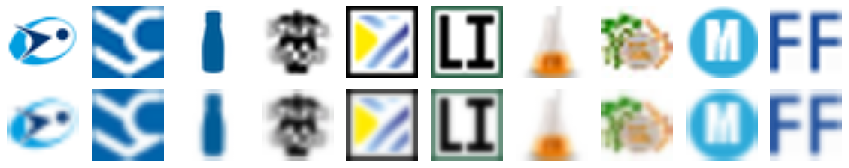

In [9]:
print("Original logos and generated low-res versions:")

images = []
    
for i in range(800,810):
    img = train_dataset.__getitem__(i)[1]
    img = denormalize(img)
    images.append(img)

for i in range(800,810):
    lrimg = train_dataset.__getitem__(i)[0]
    lrimg = denormalize(lrimg)
    images.append(lrimg)
    
images = np.array(images)

show_images(images, 10)



# Implement the Discriminator Architecture of your Design

Use Conv2d, Linear and Activation Layers to design a Discriminator

Please note: Pay attention to whether Sigmoid Unit at the last layer is added in the Architecture OR in the Loss function, because in implementations of some loss functions in Pytorch, sigmoid unit is included by default. In this notebook we use BCELoss (given default) so you should add sigmoid to last layer.

Different than normal GAN, you need to use conditional GAN approach so you should feed (lowres image, generated) and (lowres image, groundtruth) concatenated channel wise.

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6,64,3,padding=1,bias=False)
        self.conv2 = nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(2048,1024)
        self.fc2 = nn.Linear(1024,1)
        self.drop = nn.Dropout2d(0.3)
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self,x):
        block1 = self.lrelu(self.conv1(x))
        block2 = self.lrelu(self.bn2(self.conv2(block1)))
        block3 = self.lrelu(self.bn3(self.conv3(block2)))
        block4 = self.lrelu(self.bn4(self.conv4(block3)))
        block5 = self.lrelu(self.bn5(self.conv5(block4)))
        block6 = self.lrelu(self.bn6(self.conv6(block5)))
        block7 = self.lrelu(self.bn7(self.conv7(block6)))
        block8 = self.lrelu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = self.lrelu(self.fc1(block8))
        block10 = self.sigmoid(self.drop(self.fc2(block9)))
        return block10

In [11]:
discriminator = Discriminator().to("cuda").float()

# Implement the Generator Architecture of your Design

You can use (Upsample, Conv2d) pair or ConvTranspose2d and Activation Layers to design a Generator. Add Tanh to last layer for better training.

Different than normal GAN, again for conditional GAN approach you should give low res image as input to generator instead of random noise


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 3, 1, bias=False)
        
        self.ct1 = nn.ConvTranspose2d(512, 256, 6, 2, 1, bias=False)
        self.ct2 = nn.ConvTranspose2d(256, 256, 3, 2, 1, bias=False)
        self.ct3 = nn.ConvTranspose2d(256, 128, 3, 1, 1, bias=False)
        self.ct4 = nn.ConvTranspose2d(128, 48, 3, 1, 1, bias=False)
        
        self.ct5 = nn.ConvTranspose2d(48, 3, 2, 1, 0, bias=False)
             
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        self.bnct1 = nn.BatchNorm2d(256)
        self.bnct2 = nn.BatchNorm2d(256)
        self.bnct3 = nn.BatchNorm2d(128)
        self.bnct4 = nn.BatchNorm2d(48)
        
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.lrelu(self.bn3(self.conv3(x)))
        x = self.lrelu(self.bn4(self.conv4(x)))

        
        x = self.lrelu(self.bnct1(self.ct1(x)))
        x = self.lrelu(self.bnct2(self.ct2(x)))
        x = self.lrelu(self.bnct3(self.ct3(x)))
        x = self.lrelu(self.bnct4(self.ct4(x)))
        
        x = self.tanh(self.ct5(x))
            
        return x

In [13]:
generator = Generator().to("cuda").float()

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [14]:
lr = 1e-4

disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr*4)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr)

# Super Resolution GAN combines Binary Cross Entropy loss and Mean Squared Error loss, instatiated below.

In [15]:
adv_loss = nn.BCELoss()
rec_loss = nn.MSELoss()

We will create a function that generates labels with the size of batches for real inputs.

In [16]:
def get_real_label(like):
    
    label = torch.ones_like(like,dtype=torch.float)
    
    return label

We will create a function that generates labels with the size of batches for fake inputs.

In [17]:
def get_fake_label(like):
    
    label = torch.zeros_like(like,dtype=torch.float)
    
    return label

Here is a function to modify out the batch to be compatible for our network.

In [18]:
def batch_modifier(input, batch_size):
    
    return input.detach().reshape(batch_size,3,32,32).type(torch.cuda.FloatTensor)

Since we are feeding our network with the concatted real and fake images, let's create a function that does the concat operation channel-wise.

In [19]:
def concat_inputs(i1, i2):
    return torch.cat((i1, i2), axis=1)

# Implement train and validation code below. Calculate Average PSNR for validation set.

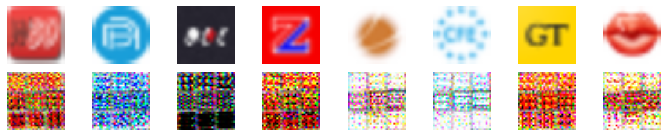

epoch: {1}, batch number: {2500}, disc_error: {0.2599}, gen_error: {9.0818}
epoch: {1}, batch number: {5000}, disc_error: {0.3466}, gen_error: {8.3291}
epoch: {1}, batch number: {7500}, disc_error: {0.3469}, gen_error: {12.3085}
epoch: {1}, batch number: {10000}, disc_error: {0.3466}, gen_error: {14.8854}
epoch: {1}, batch number: {12500}, disc_error: {0.1745}, gen_error: {8.8358}
epoch: {1}, batch number: {15000}, disc_error: {1.1080}, gen_error: {3.5233}
epoch: {1}, batch number: {17500}, disc_error: {0.2611}, gen_error: {8.1269}
epoch: {1}, batch number: {20000}, disc_error: {0.6065}, gen_error: {21.8190}


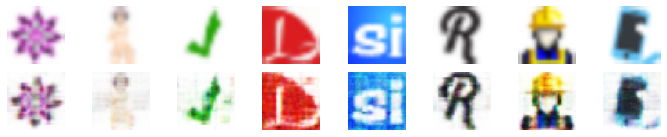

epoch: {1}, batch number: {22500}, disc_error: {0.3466}, gen_error: {12.4612}
epoch: {1}, batch number: {25000}, disc_error: {0.6932}, gen_error: {18.5113}
epoch: {1}, batch number: {27500}, disc_error: {0.3466}, gen_error: {12.1245}
epoch: {1}, batch number: {30000}, disc_error: {0.2600}, gen_error: {19.7051}
epoch: {1}, batch number: {32500}, disc_error: {0.5203}, gen_error: {3.6668}
epoch: {1}, batch number: {35000}, disc_error: {0.6931}, gen_error: {26.7470}
epoch: {1}, batch number: {37500}, disc_error: {0.4332}, gen_error: {10.8912}
epoch: {1}, batch number: {40000}, disc_error: {0.2599}, gen_error: {17.1562}


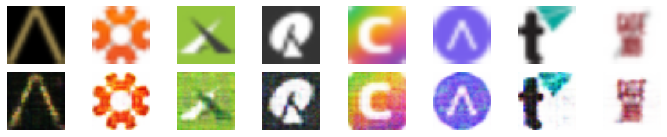

epoch: {1}, batch number: {42500}, disc_error: {0.2599}, gen_error: {11.9621}
epoch: {1}, batch number: {45000}, disc_error: {0.3469}, gen_error: {12.8959}
epoch: {1}, batch number: {47500}, disc_error: {0.4332}, gen_error: {16.7080}
epoch: {1}, batch number: {50000}, disc_error: {0.5199}, gen_error: {20.0822}


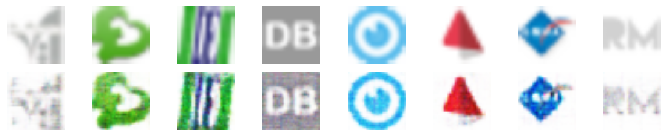

epoch: {2}, batch number: {2500}, disc_error: {0.4775}, gen_error: {5.1035}
epoch: {2}, batch number: {5000}, disc_error: {0.6065}, gen_error: {7.4654}
epoch: {2}, batch number: {7500}, disc_error: {0.2600}, gen_error: {10.7811}
epoch: {2}, batch number: {10000}, disc_error: {0.5199}, gen_error: {7.8756}
epoch: {2}, batch number: {12500}, disc_error: {0.6932}, gen_error: {8.5732}
epoch: {2}, batch number: {15000}, disc_error: {0.4333}, gen_error: {10.1409}
epoch: {2}, batch number: {17500}, disc_error: {0.3568}, gen_error: {3.1302}
epoch: {2}, batch number: {20000}, disc_error: {0.6065}, gen_error: {14.5651}


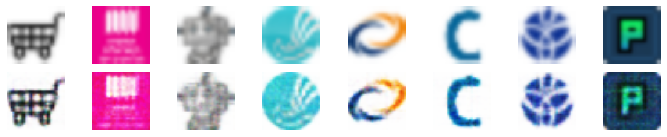

epoch: {2}, batch number: {22500}, disc_error: {0.4332}, gen_error: {13.5457}
epoch: {2}, batch number: {25000}, disc_error: {0.8664}, gen_error: {5.3562}
epoch: {2}, batch number: {27500}, disc_error: {0.4332}, gen_error: {7.8922}
epoch: {2}, batch number: {30000}, disc_error: {0.5199}, gen_error: {18.0595}
epoch: {2}, batch number: {32500}, disc_error: {0.6065}, gen_error: {15.7469}
epoch: {2}, batch number: {35000}, disc_error: {0.2599}, gen_error: {14.6854}
epoch: {2}, batch number: {37500}, disc_error: {0.5199}, gen_error: {9.8801}
epoch: {2}, batch number: {40000}, disc_error: {0.0871}, gen_error: {6.5082}


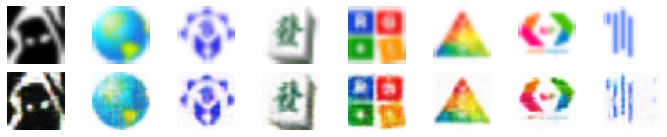

epoch: {2}, batch number: {42500}, disc_error: {0.4095}, gen_error: {2.8603}
epoch: {2}, batch number: {45000}, disc_error: {0.6932}, gen_error: {9.6952}
epoch: {2}, batch number: {47500}, disc_error: {0.4333}, gen_error: {4.9178}
epoch: {2}, batch number: {50000}, disc_error: {0.0866}, gen_error: {10.5785}


In [20]:
num_epochs = 2

l_gen = []
l_disc = []

for epoch in range(num_epochs):
    for n_batch, (x_low, x) in enumerate(train_loader):

        # We are modifying our batches for our network
        x_low = batch_modifier(x_low, batch_size)
        x = batch_modifier(x, batch_size)
        
        # Zeroing the discriminator network's gradients
        discriminator.zero_grad()
        
        # Forward-pass on generator
        generated = generator(x_low)
        
        # Concatted input for real and fake data
        fakeandlr = concat_inputs(generated, x_low)
        realandlr = concat_inputs(x, x_low)
        
        # Forward-pass on discriminator with real and fake data
        f_label = discriminator(fakeandlr)
        r_label = discriminator(realandlr)
        
        # Creating ground-truth fake and real labels
        fake_gt = get_fake_label(f_label)
        real_gt = get_real_label(r_label)
        
        # Calculating BCE loss for fake labels
        f_loss = torch.mean(adv_loss(f_label, fake_gt))
        
        # Calculating BCE loss for real labels
        r_loss = torch.mean(adv_loss(r_label, real_gt))
        
        # Getting total loss for discriminator
        d_loss = f_loss + r_loss
        
        # Calculating gradients the loss
        
        d_loss.backward(retain_graph=True)
        
        # Running optimizer for discriminator
        disc_optimizer.step()
        
        # Zeroing the generator network's gradients
        generator.zero_grad()
        
        # Forward-pass on the updated discriminator with fake data
        with torch.no_grad():
            f_label = discriminator(fakeandlr)
        
        # Calculating BCE loss for generated images, to train generator, we assume all of the generated images are real
        gen_loss = adv_loss(f_label, real_gt)
        
        # Calculating reconstruction loss (MSE)
        mse_loss = rec_loss(generated, x)
        
        # Getting total loss for generator
        generator_loss = torch.sum(gen_loss + mse_loss)
        
        # Calculating gradients for the total loss
        generator_loss.backward()
        
        # Running optimizer for generator
        gen_optimizer.step()
          
        if (n_batch + 1) % 2500 == 0:
            print("epoch: {%d}, batch number: {%d}, disc_error: {%.4f}, gen_error: {%.4f}" % 
                  (epoch + 1, n_batch + 1, d_loss.item(), generator_loss.item()))
            
        if (n_batch) % 20000 == 0:
            with torch.no_grad():
                
                images = []
                
                # Printing low-res images
                imgs_numpy = x_low.detach().cpu().numpy()
        
                for img in imgs_numpy[:8]:
                    img = img.reshape([32, 32, 3])
                    img = denormalize(img)
                    images.append(img)
                
                # Printing generated super-res images
                imgs_numpy = generator(x_low).detach().cpu().numpy()
                
                for img in imgs_numpy[:8]:
                    img = img.reshape([32, 32, 3])
                    img = denormalize(img)
                    images.append(img)
          
                images = np.array(images)
            
                # Showing the samples
                show_images(images, 8)
                
        # Saving losses
        l_gen.append(generator_loss.item())
        l_disc.append(d_loss.item())

## Report the training loss curves and test results (generated images) of your model. Also briefly discuss the results.

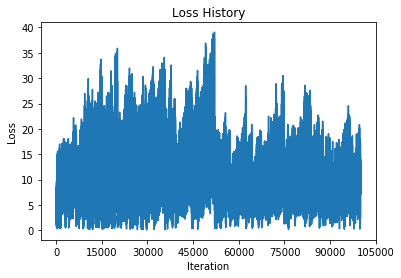

In [21]:
# Plot Generator Loss 

set_size = np.arange(len(l_gen))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(set_size, l_gen)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss History")
plt.show()

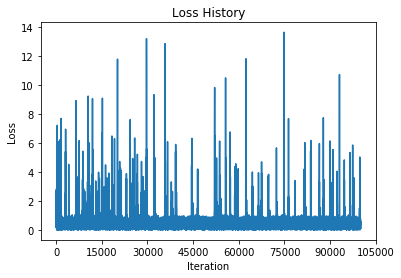

In [22]:
# Plot Discriminator Loss

set_size = np.arange(len(l_disc))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(set_size, l_disc)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("Loss History")
plt.show()

Samples from the final generator model are as follows

In Order: Low-Res, Original, Generated Super-Res


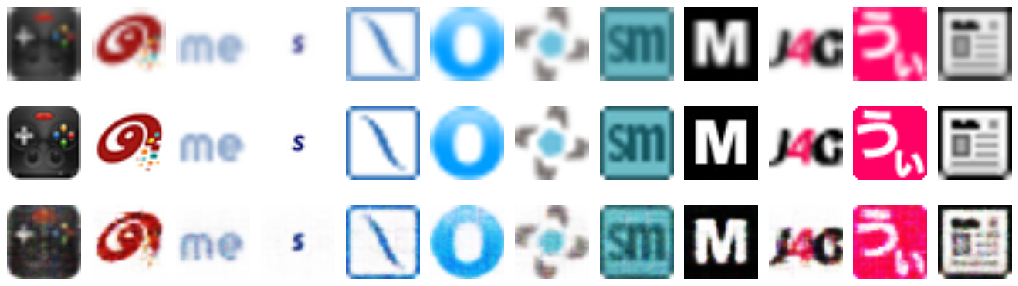

In [23]:
print("In Order: Low-Res, Original, Generated Super-Res")

images = []

for n_batch, (x_low, x) in enumerate(test_loader):
    
        x_low = batch_modifier(x_low, 12)
        x = batch_modifier(x, 12)
        
        with torch.no_grad():  
                
                # Printing low-res images
                imgs_numpy = x_low.detach().cpu().numpy()
        
                for img in imgs_numpy:
                    img = img.reshape([32, 32, 3])
                    img = denormalize(img)
                    images.append(img)
                    
                # Printing hi-res images
                imgs_numpy = x.detach().cpu().numpy()
        
                for img in imgs_numpy:
                    img = img.reshape([32, 32, 3])
                    img = denormalize(img)
                    images.append(img)
                    
                # Printing generated super-res images
                imgs_numpy = generator(x_low).detach().cpu().numpy()
                
                for img in imgs_numpy:
                    img = img.reshape([32, 32, 3])
                    img = denormalize(img)
                    images.append(img)
          
                images = np.array(images)
            
                # Showing the samples
                show_images(images, 12)
            
        if n_batch==0:
            break

In [24]:
disc_avg_l = np.mean(l_disc[-1000:-1])
gen_avg_l = np.mean(l_gen[-1000:-1])

print("Average Discriminator Loss: " + str(disc_avg_l))
print("Average Generator Loss: " + str(gen_avg_l))

Average Discriminator Loss: 0.42682107995944835
Average Generator Loss: 10.371681092051533


We actually want discriminator loss to converge on 0.5. Because it's the uncertainty state and the discriminator would not really know if the given image is real or fake. We calculated the mean of the latest discrimator loss as close to 0.5 despite the spikes, so our generator is good enough to fool our discriminator.

#### After you have completed the training, save your generator model using the following command

In [25]:
student_id = 504181504
torch.save(generator.state_dict(),'./{}_SR.pth'.format(student_id))